In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras import regularizers

# Load data
data_folder = '/app/data'

# Lagrangian Approaches for Constrained Machine Learning

What if we have hard constraints?

## Constrained Machine Learning

**Let's consider again our Lagrangian Relaxation for constrained ML**

In particular, let's focus on problems in the form:
$$
\arg\min_{\theta} \left\{ L({\bf y}) + \lambda^T \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$

* We claimed there is no trivial constraint satisfaction guarantee
* ...But what about _non-trivial_ ones? ;-)

**What if we have an _optimal_ solver and sufficiently _large $\lambda$_?**

In this case, whenever the constraints are violated $L$ become negligible

* It's like optimizing a _lexicographic cost function_
* ...And we can guarantee constraint satisfaction (if at all possible)

## Penalty Method

**This is the core idea in the classical _penalty method_**

* $\lambda^{(0)} = {\bf 1}$
* $\theta^{(0)} = \arg\min_{\theta} \left\{ L({\bf y}) + \lambda^{(0)T} \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)$
* For $k = 1..n$
  - If $g({\bf y}) \leq 0$, stop
  - Otherwise $\lambda^{(k)} = r\lambda^{(k)}$
  - $\theta^{(k)} = \arg\min_{\theta} \left\{ L({\bf y}) + \lambda^{(k)T} \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)$
 
 
**The main idea is simply to make $\lambda$ large enough**

* It works even with non differentiable constraints
* ...If your training engine can handle them, that is

## Drawbacks of the Penalty Method

**The penalty method can be quite effective, but it has some _drawbacks_:**

1. You need an optimal solver
   * Without one, you only get approximate results (no guarantees)
2. The $\max$ (or square) is important
   * Without that, penalties turn into rewards for satisfied constraints
3. You may need arbitrarily large weights:

<center><img src="assets/pm_fail.png" width="550px"/></center>

## Lagrangian Dual Approach

**A nice compromise is provided by the _Lagrangian Dual approach_ [2]**

We start from the fact that solving:
$$
\min_{\theta} \left\{ L({\bf y}) + \lambda^T \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
...Always provides a _lower bound_ on the true constrained optimum

* The reason is that on the original feasible space, all penalty terms are 0
* ...And therefore the minimum cannot be worse than the original one

**Therefore, it makes sense to pick $\lambda$ so as to _maximize this bound_**

$$
\arg \max_{\lambda} \min_{\theta} \left\{ L({\bf y}) + \lambda^T \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$

Solving this problem given the best possible lower bound

## Lagrangian Dual Approach

**Now, let's look more carefully at our problem:**

\begin{align}
& \arg \max_{\lambda} \min_\theta \mathcal{L(\lambda, \theta)} \\
\text{where: } & \mathcal{L(\lambda, \theta)} = L({\bf y}) + \lambda^T \max(0, g({\bf y})) \\
\text{ with: } & {\bf y} = f({\bf x}; \theta)
\end{align}

**This is a _bi-level optimization problem_**

It can be proved that it is _concave in $\lambda$_

* Therefore, it can be solved via _sub-gradient_ descent
* ...Even for non-differentiable $L$, $g$, and $f$

**By doing so, we increase $\lambda$ only _when and where_ it is needed**

* It is a _strong mitigation_ for the issues of the penalty method 


## Lagrangian Dual Approach

**If additionally $\mathcal{L}(\lambda, \theta)$ is differentiable in $\theta$**

...Then we can solve the problem via alternate _gradient descent/ascent_:

* $\lambda^{(0)} = {\bf 0}$
* $\theta^{(0)} = \arg \min_\theta \mathcal{L}(\lambda^{(0)}, \theta)$
* For $k = 1..n$ (or until convergence):
  - Obtain $\lambda^{(k)}$ via an ascent step with sub-gradient $\nabla_{\lambda} \mathcal{L}(\lambda, \theta^{(k-1)})$
  - Obtain $\theta^{(k)}$ via a descent step with sub-gradient $\nabla_{\theta} \mathcal{L}(\lambda^{(k)}, \theta)$

**The approach is easy to implement in tensorflow/PyTorch**

We just need to use two optimization steps

* It works since small changes to $\lambda$
* ...Usually require small changes to $\theta$
* Hence, we can maintain the two vectors approximately optimal 

## References

* [1] Diligenti, Michelangelo, Marco Gori, and Claudio Sacca. "Semantic-based regularization for learning and inference." Artificial Intelligence 244 (2017): 143-165.
* [2] Ferdinando Fioretto, Pascal Van Hentenryck, Terrence W. K. Mak, Cuong Tran, Federico Baldo, Michele Lombardi: Lagrangian Duality for Constrained Deep Learning. ECML/PKDD (5) 2020: 118-135

# A Case Study: Fairness in Machine Learning

## Fairness Issues in Machine Learning

**Say we want to estimate the risk of violent crimes in given population**

<center><img src="assets/minority-report.jpg" width=800px/></center>

* This is obviously a very _ethically sensitive (and questionable) task_
* Our model may easily end up discriminating some social groups

**Which makes it a good test case for _fairness issues in data-driven models_**


## Loading and Preparing the Dataset

**We will start by loading the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

We will use a pre-processed version:

In [2]:
data = cst.load_communities_data(data_folder)
attributes = data.columns[3:-1]
target = data.columns[-1]
data.head()

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28


The target is "violentPerPop" (number of violent offenders per 100K people)

## Loading and Preparing the Dataset

**We prepare for normalizing all numeric attributes**

* The only categorical input is "race" (0 = primarily white, 1 = primarily black)
* Incidentally, "race" is _a natural focus to check for discrimination_

**We define the train-test divide and we identify the numerical inputs**

In [3]:
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
nf = [a for a in attributes if a != 'race'] + [target]

We compute the normalization constants and we transform the data

In [4]:
tmp = data.iloc[:tr_sep]
scale = tmp[nf].max()
sdata = data.copy()
sdata[nf] /= scale[nf]

Then we convert all data to a "float32" format (for tensorflow compatibility)

In [22]:
sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

## Loading and Preparing the Dataset

**Finally we can separate the training and test set**

In [5]:
tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]
tr.describe()

,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,...,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,5.515056,0.007309,0.031995,0.266962,0.398600,0.230577,0.226739,0.695383,0.272795,0.808877,...,0.126063,0.649192,0.651699,0.796561,0.886649,0.009499,0.062829,0.057092,0.021317,0.118508
std,2.912637,0.030287,0.176042,0.084005,0.090329,0.098553,0.091256,0.445105,0.108972,0.081297,...,0.144243,0.183083,0.135358,0.112796,0.077034,0.028955,0.065060,0.092881,0.061344,0.123444
min,1.000000,0.001368,0.000000,0.084191,0.134635,0.075644,0.031457,0.000000,0.104413,0.327882,...,0.003182,0.072472,0.150586,0.289367,0.332187,0.000335,0.000226,0.000000,0.000000,0.001097
25%,3.000000,0.001943,0.000000,0.225230,0.350689,0.185238,0.167614,0.000000,0.190973,0.759677,...,0.035541,0.525016,0.566446,0.743167,0.854675,0.002754,0.026280,0.006672,0.000000,0.032800
50%,5.000000,0.003035,0.000000,0.250919,0.385173,0.205575,0.223138,1.000000,0.249509,0.813755,...,0.075352,0.669369,0.658096,0.819391,0.905697,0.005099,0.045234,0.022823,0.000000,0.076430
75%,8.000000,0.005922,0.000000,0.283824,0.419908,0.235735,0.275298,1.000000,0.334641,0.866125,...,0.155517,0.798529,0.744017,0.875764,0.938556,0.009667,0.074085,0.064651,0.000000,0.159716
max,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
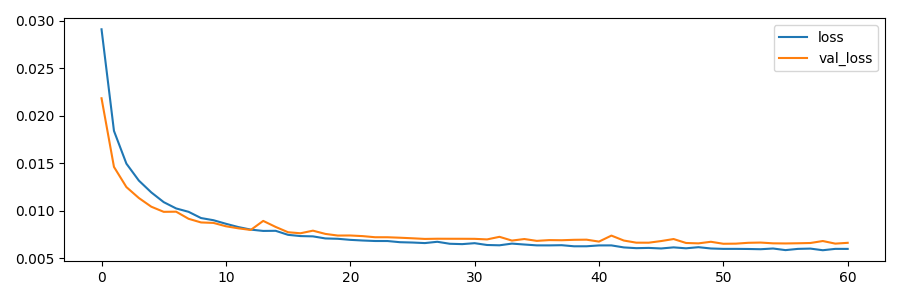

In [6]:
nn = cst.MLPRegressor(input_shape=len(attributes), hidden=[])
nn.compile(optimizer='Adam', loss='mse')
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = nn.fit(tr[attributes], tr[target], batch_size=32, epochs=200, verbose=0,
                 validation_split=0.2, callbacks=cb)
cst.plot_training_history(history)

## Baseline Evaluation

**...And let's check the results**

In [7]:
tr_pred = nn.predict(tr[attributes])
r2_tr = r2_score(tr[target], tr_pred)
mae_tr = mean_absolute_error(tr[target], tr_pred)

ts_pred = nn.predict(ts[attributes])
r2_ts = r2_score(ts[target], ts_pred)
mae_ts = mean_absolute_error(ts[target], ts_pred)

print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'MAE: {mae_tr:.2f} (training), {mae_ts:.2f} (test)')

R2 score: 0.61 (training), 0.55 (test)
MAE: 0.05 (training), 0.06 (test)


* They are not super (definitely not [PreCrime](https://en.wikipedia.org/wiki/Minority_Report_(film)) level), but not alwful either
* Some improvements (not much) can be obtained with a Deeper model

**We will keep Linear Regression as a baseline**

# Fairness Constraints

## Discrimination Indexes

**Discrimination can be linked to _disparate treatment_**

* "race" _may not be even among the input attributes_
* ...And yet it may be taken into account implicitly (i.e. via correlates)

**But we can check whether the model _treats differently different groups_:**


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
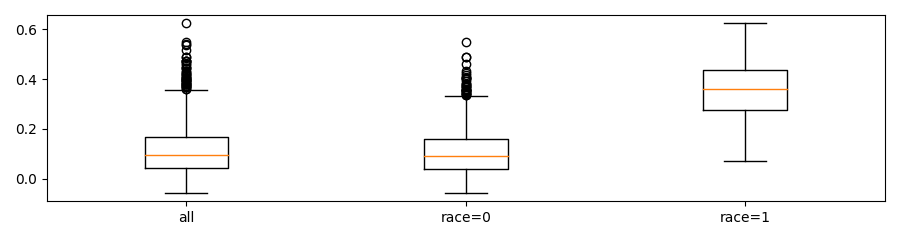

In [8]:
protected = {'race': (0, 1)}
cst.plot_pred_by_protected(tr, tr_pred, protected, figsize=(figsize[0], 0.8*figsize[1]))

Indeed, our model has a significant degree of discrimination

## Discrimination Indexes

**A number of _discrimination indexes_ attempt to measure discrimination**

* Whether ethics itself can be measured is _highly debatable_!
* ...But even if imperfect, this currently the best we can do

**We will use the Disparate Impact Discrimination Index**

...Which was introduced in a [AAAI paper](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The regression for of the regression form of the index ($\text{DIDI}_r$) is given by:

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




## DIDI

**Let's make some intuitive sense of the $\text{DIDI}_r$ formula**

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* $\frac{1}{m} \sum_{i=1}^m y_i$ is just the average predicted value
* The protected attribute defines social groups
* $\frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}$ is the average prediction for a social group

**We penalize _deviations from the global average_**

* Obviously this is not necessarily the best definition, but it is something
* In general, different tasks will call for different discrimination indexes

...And don't forget the whole "can we actually measure ethics" issue ;-)

## DIDI

**We can compute the DIDI via the following function**

```python
def DIDI_r(data, pred, protected):
    res, avg = 0, np.mean(pred)
    for aname, dom in protected.items():
        for val in dom:
            mask = (data[aname] == val)
            res += abs(avg - np.mean(pred[mask]))
    return res
```

* `protected` contains the protected attribute names with their domain

**For our original Linear Regression model, we get**

In [9]:
tr_DIDI = cst.DIDI_r(tr, tr_pred, protected)
ts_DIDI = cst.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 0.25 (training), 0.25 (test)


This is our baseline discrimination level

## Fairness Constraints

**Discrimination indexes can be used to state fairness constraints**

For example, we may require:
$$
\text{DIDI}_r(y) \leq \theta
$$

**If the chosen index is _differentiable_...**

...Then we may try to inject the constraint in a NN via a _semantic regularizer_

* For example, we may use a loss function in the form:
$$
L(y, \hat{y}) + \lambda \max(0, \text{DIDI}_r(y) - \theta)
$$

For non-differentiable indexes (e.g. those found in classification), we can:

* Use a differentiable approximation (with some care!)
* Use an approach that does not require differentiability, e.g. [this](https://arxiv.org/abs/2002.10766) or [that](https://link.springer.com/content/pdf/10.1007/s10115-011-0463-8.pdf)



## Fairness as a Semantic Regularizer

**We can once again use a custom Keras model**

```python
class CstDIDIRegressor(MLPRegressor):
    def __init__(self, attributes, protected, alpha, thr, hidden=[]): ...

    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

The full code can be found in the support module

* We subclass our `MLPRegressor` (itself a subclass of `keras.Model`)
* ...And we provide a custom training step
* `alpha` is the regularizer weight
* `thr` is the DIDI threshold

In this case, we do not need a custom batch generator

## Fairness as a Semantic Regularizer

**The main logic is in the first half of the `train_step` method:**

```python
def train_step(self, data):
    x, y_true = data # unpacking the mini-batch
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) # obtain predictions
        mse = self.compiled_loss(y_true, y_pred) # base loss (kept external)
        ymean = k.mean(y_pred) # avg prediction
        didi = 0 # DIDI computation
        for aidx, dom in self.protected.items():
            for val in dom:
                mask = (x[:, aidx] == val)
                didi += k.abs(ymean - k.mean(y_pred[mask]))
        cst = k.maximum(0.0, didi - self.thr) # Regularizer
        loss = mse + self.alpha * cst
```

* In this case we chose to let the main loss be defined externally
* ...Which means we will need to define it when calling `compile`

## Training the Constrained Model

**Let's try and train the model, trying to roughly halve the DIDI**

Important: it will be a good idea to need to keep all examples in every batch

* Mini-batches can be used, but make constraint satisfaction (more) stochastic

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
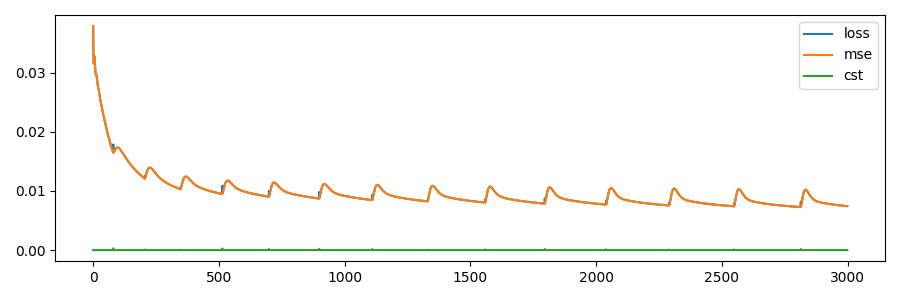

In [10]:
didi_thr = 0.13
nn3 = cst.CstDIDIRegressor(attributes, protected, alpha=5, thr=didi_thr, hidden=[])

nn3.compile(optimizer='Adam', loss='mse')
history3 = nn3.fit(tr[attributes], tr[target], batch_size=len(tr), epochs=3000, verbose=0)
cst.plot_training_history(history3)

## Constrained Model Evaluation

**Let's check both the prediction quality and the DIDI**

In [11]:
tr_pred3 = nn3.predict(tr[attributes])
r2_tr3 = r2_score(tr[target], tr_pred3)
mae_tr3 = mean_absolute_error(tr[target], tr_pred3)

ts_pred3 = nn3.predict(ts[attributes])
r2_ts3 = r2_score(ts[target], ts_pred3)
mae_ts3 = mean_absolute_error(ts[target], ts_pred3)

tr_DIDI3 = cst.DIDI_r(tr, tr_pred3, protected)
ts_DIDI3 = cst.DIDI_r(ts, ts_pred3, protected)

print(f'R2 score: {r2_tr3:.2f} (training), {r2_ts3:.2f} (test)')
print(f'MAE: {mae_tr3:.2f} (training), {mae_ts3:.2f} (test)')
print(f'DIDI: {tr_DIDI3:.2f} (training), {ts_DIDI3:.2f} (test)')

R2 score: 0.51 (training), 0.45 (test)
MAE: 0.06 (training), 0.07 (test)
DIDI: 0.11 (training), 0.10 (test)


* The constraint is satisfied _with some slack_, leading to reduced performance

**The issue is related to the choice of the _correct regularizer weight_**


## Implementing the Lagrangian Dual Approach

**We will implement the Lagrangian dual approach via another custom model**

```python
class LagDualDIDIRegressor(MLPRegressor):
    def __init__(self, attributes, protected, thr, hidden=[]):
        super(LagDualDIDIRegressor, self).__init__(len(attributes), hidden)
        self.alpha = tf.Variable(0., name='alpha')
        ...

    def __custom_loss(self, x, y_true, sign=1): ...

    def train_step(self, data): ...
        
    def metrics(self): ...
```

* We no longer pass a fixed `alpha` weight/multiplier
* Instead we use a _trainable variable_

## Implementing the Lagrangian Dual Approach

**In the `__custom_loss` method we compute the Lagrangian/regularized loss**

```python
def __custom_loss(self, x, y_true, sign=1):
    y_pred = self(x, training=True) # obtain the predictions
    mse = self.compiled_loss(y_true, y_pred) # main loss
    ymean = k.mean(y_pred) # average prediction
    didi = 0 # DIDI computation
    for aidx, dom in self.protected.items():
        for val in dom:
            mask = (x[:, aidx] == val)
            didi += k.abs(ymean - k.mean(y_pred[mask]))
    cst = k.maximum(0.0, didi - self.thr) # regularizer
    loss = mse + self.alpha * cst
    return sign*loss, mse, cst
```

* The code is the same as before
* ...Except that we can flip the loss sign via a function argument (i.e. `sign`)

## Implementing the Lagrangian Dual Approach

**In the training method, we make _two distinct gradient steps:_**

```python
    def train_step(self, data):
        x, y_true = data # unpacking
        with tf.GradientTape() as tape: # first loss (minimization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=1)
        # Separate training variables
        tr_vars = self.trainable_variables
        wgt_vars = tr_vars[:-1] # network weights
        mul_vars = tr_vars[-1:] # multiplier
        grads = tape.gradient(loss, wgt_vars) # adjust the network weights
        self.optimizer.apply_gradients(zip(grads, wgt_vars))
        with tf.GradientTape() as tape: # second loss (maximization)
            loss, mse, cst = self.__custom_loss(x, y_true, sign=-1)
        grads = tape.gradient(loss, mul_vars) # adjust lambda
        self.optimizer.apply_gradients(zip(grads, mul_vars))
```

* In principle, we could even have used two distinct optimizers
* That would allow to keep (e.g.) separate momentum vectors

## Training the Lagrangian Dual Approach

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
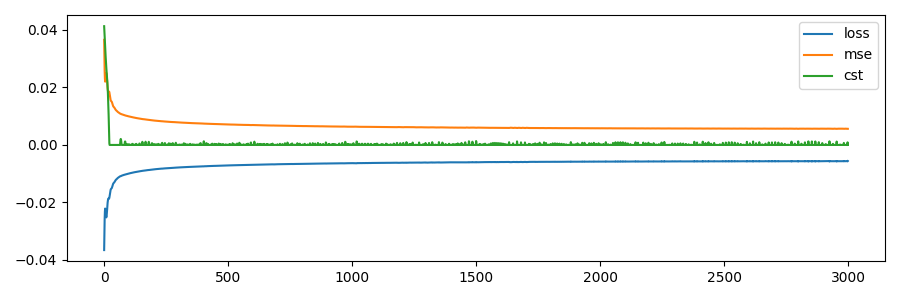

In [12]:
nn4 = cst.LagDualDIDIRegressor(attributes, protected, thr=didi_thr, hidden=[])
nn4.compile(optimizer='Adam', loss='mse')
history4 = nn4.fit(tr[attributes], tr[target], batch_size=len(tr), epochs=3000, verbose=0)

cst.plot_training_history(history4)

## Lagrangian Dual Evaluation

**Let's check the new results**

In [13]:
tr_pred4 = nn4.predict(tr[attributes])
r2_tr4 = r2_score(tr[target], tr_pred4)
mae_tr4 = mean_absolute_error(tr[target], tr_pred4)

ts_pred4 = nn4.predict(ts[attributes])
r2_ts4 = r2_score(ts[target], ts_pred4)
mae_ts4 = mean_absolute_error(ts[target], ts_pred4)

print(f'R2 score: {r2_tr4:.2f} (training), {r2_ts4:.2f} (test)')
print(f'MAE: {mae_tr4:.2f} (training), {mae_ts4:.2f} (test)')

tr_DIDI4 = cst.DIDI_r(tr, tr_pred4, protected)
ts_DIDI4 = cst.DIDI_r(ts, ts_pred4, protected)
print(f'DIDI: {tr_DIDI4:.2f} (training), {ts_DIDI4:.2f} (test)')

R2 score: 0.63 (training), 0.57 (test)
MAE: 0.05 (training), 0.06 (test)
DIDI: 0.13 (training), 0.15 (test)


* The DIDI has the desired value (on the test set, this is only roughly true)
* ...And the prediction quality is _much higher than before_!